# Performance Analysis with Alphalens

## Imports & Settings

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

# Get the current working directory
path = os.getcwd()

# Print the path
print("Current Path:", path)

# 이동할 디렉토리 경로
path = '/content/drive/MyDrive/Colab Notebooks'

# 디렉토리 변경
os.chdir(path)

Current Path: /content


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install alphalens

                                              0.0/24.0 MB ? eta -:--:--
                                              0.5/24.0 MB 14.2 MB/s eta 0:00:02
     --                                       1.3/24.0 MB 13.4 MB/s eta 0:00:02
     ---                                      1.9/24.0 MB 14.7 MB/s eta 0:00:02
     ----                                     2.8/24.0 MB 14.8 MB/s eta 0:00:02
     ------                                   3.7/24.0 MB 16.9 MB/s eta 0:00:02
     -------                                  4.5/24.0 MB 17.1 MB/s eta 0:00:02
     ----------                               6.3/24.0 MB 19.0 MB/s eta 0:00:01
     -------------                            8.2/24.0 MB 20.9 MB/s eta 0:00:01
     -------------                            8.4/24.0 MB 20.6 MB/s eta 0:00:01
     -------------                            8.4/24.0 MB 20.6 MB/s eta 0:00:01
     ---------------                          9.1/24.0 MB 16.7 MB/s eta 0:00:01
     -----------------                       10.


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [5]:
sns.set_style('whitegrid')

In [6]:
np.random.seed(42)
idx = pd.IndexSlice

In [7]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Alphalens Analysis

### Load predictions

In [8]:
DATA_STORE = Path(results_path / 'data.h5')

In [9]:
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [10]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

### Get trade prices

In [11]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2014':'2020'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

In [12]:
trade_prices = get_trade_prices(tickers)

In [13]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2014-01-03 00:00:00+00:00 to 2020-01-03 00:00:00+00:00
Freq: W-FRI
Columns: 3825 entries, A to ZYXI
dtypes: float64(3825)
memory usage: 9.2 MB


In [14]:
trade_prices.to_hdf('tmp.h5', 'trade_prices')

### Generate tearsheet input

In [15]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 19.9% entries from factor data: 19.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 796888 entries, (Timestamp('2015-01-09 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2019-08-09 00:00:00+0000', tz='UTC', freq='C'), 'ZYXI')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               796888 non-null  float64
 1   10D              796888 non-null  float64
 2   21D              796888 non-null  float64
 3   factor           796888 non-null  float32
 4   factor_quantile  796888 non-null  int64  
dtypes: float32(1), float64(3), int64(1)
memory usage: 30.6+ MB


### Create Tearsheet

In [16]:
factor_data

5D       10D       21D    factor  \
date                      asset                                           
2015-01-09 00:00:00+00:00 A     -0.014775  0.037183 -0.006176  0.362072   
                          AA    -0.032399 -0.209548 -0.240872  0.262771   
                          AAIC  -0.043313 -0.042553 -0.184666  0.392397   
                          AAL   -0.042914  0.088570 -0.192370  0.180841   
                          AAOI   0.008946  0.376740  0.801193  0.354270   
...                                   ...       ...       ...       ...   
2019-08-09 00:00:00+00:00 ZUO    0.064029 -0.010791  0.010791  0.090833   
                          ZVRA  -0.308652 -0.532346 -0.668745  0.118833   
                          ZWS    0.035196  0.006531  0.185777  0.080281   
                          ZYME   0.032494  0.203087  0.823721  0.059168   
                          ZYXI   0.084236  0.257521 -0.056558  0.071558   

                                 factor_quantile  
date                      asset                   
2015-01-09 00:00:00+00:00 A                    4  
                          AA                   1  
                          AAIC                 5  
                          AAL                  1  
                          AAOI                 4  
...                                          ...  
2019-08-09 00:00:00+00:00 ZUO                  4  
                          ZVRA                 5  
                          ZWS                  4  
                          ZYME                 2  
                          ZYXI                 3  

[796888 rows x 5 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.482378,0.325661,0.188294,0.070763,159472,20.011846
2,0.035894,0.361192,0.225180,0.060655,159327,19.993650
3,0.060652,0.386964,0.242609,0.063380,159331,19.994152
4,0.072186,0.414150,0.258231,0.065408,159327,19.993650
5,0.085284,0.835098,0.280883,0.069256,159431,20.006701


Returns Analysis


,5D,10D,21D
Ann. alpha,-0.088,-0.091,-0.055
beta,0.084,0.076,0.050
Mean Period Wise Return Top Quantile (bps),-5.677,-11.374,-4.962
Mean Period Wise Return Bottom Quantile (bps),15.044,13.737,11.355
Mean Period Wise Spread (bps),-20.721,-24.983,-16.093


Information Analysis


,5D,10D,21D
IC Mean,-0.008,-0.015,-0.019
IC Std.,0.075,0.068,0.074
Risk-Adjusted IC,-0.105,-0.222,-0.254
t-stat(IC),-1.622,-3.437,-3.934
p-value(IC),0.106,0.001,0.000
IC Skew,0.605,0.120,-0.400
IC Kurtosis,1.282,0.228,0.309


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.551,0.601,0.663
Quantile 2 Mean Turnover,0.734,0.752,0.772
Quantile 3 Mean Turnover,0.752,0.765,0.777
Quantile 4 Mean Turnover,0.736,0.752,0.771
Quantile 5 Mean Turnover,0.586,0.621,0.677


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.44,0.372,0.266


<Figure size 640x480 with 0 Axes>

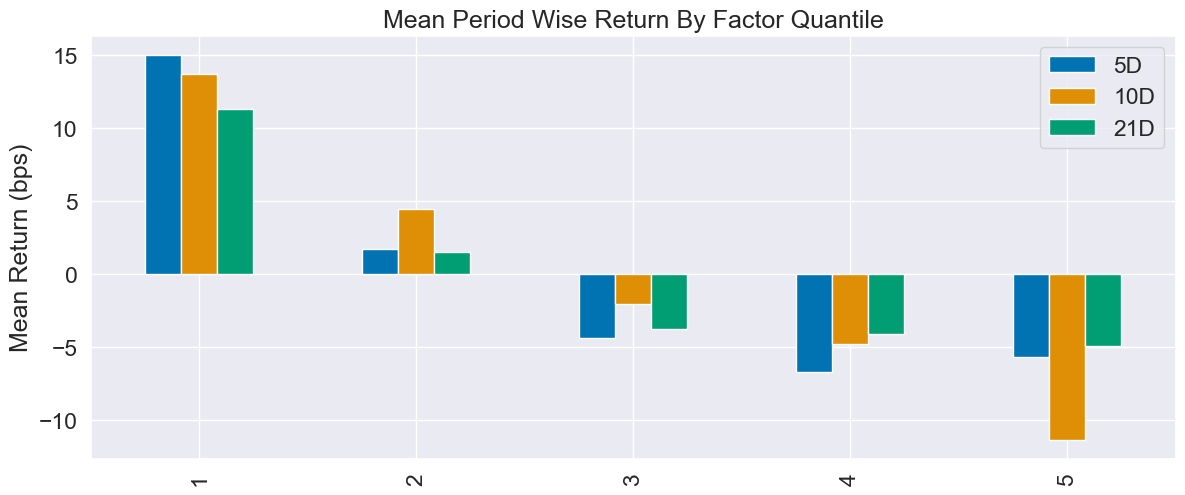

In [17]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.482378,0.325661,0.188294,0.070763,159472,20.011846
2,0.035894,0.361192,0.225180,0.060655,159327,19.993650
3,0.060652,0.386964,0.242609,0.063380,159331,19.994152
4,0.072186,0.414150,0.258231,0.065408,159327,19.993650
5,0.085284,0.835098,0.280883,0.069256,159431,20.006701


Returns Analysis


,5D,10D,21D
Ann. alpha,-0.088,-0.091,-0.055
beta,0.084,0.076,0.050
Mean Period Wise Return Top Quantile (bps),-5.677,-11.374,-4.962
Mean Period Wise Return Bottom Quantile (bps),15.044,13.737,11.355
Mean Period Wise Spread (bps),-20.721,-24.983,-16.093


<Figure size 640x480 with 0 Axes>

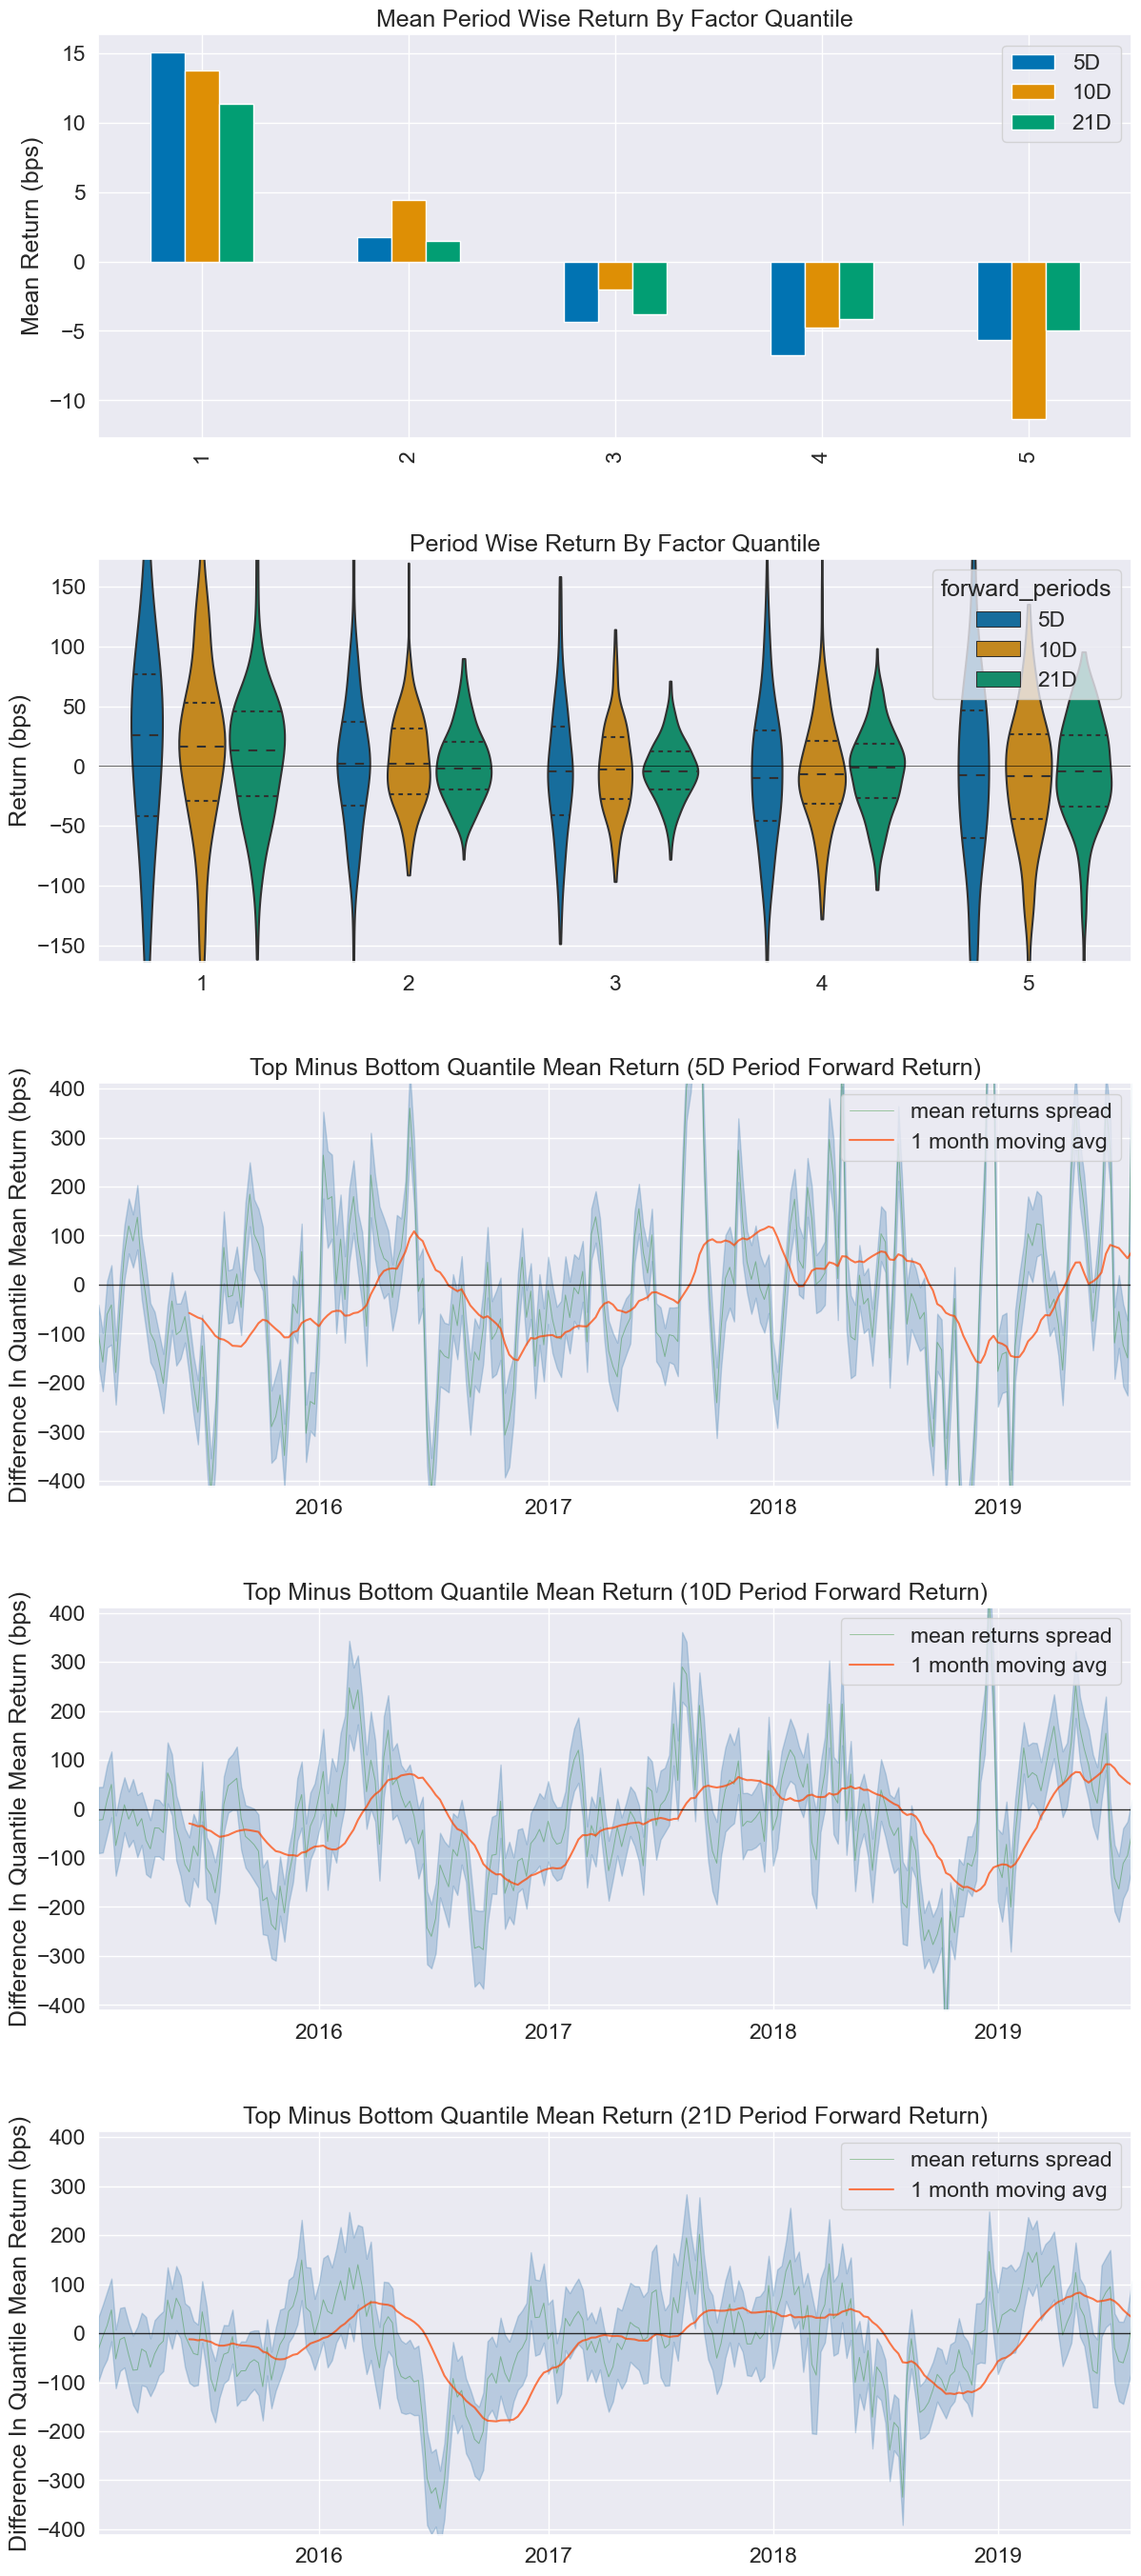

Information Analysis


,5D,10D,21D
IC Mean,-0.008,-0.015,-0.019
IC Std.,0.075,0.068,0.074
Risk-Adjusted IC,-0.105,-0.222,-0.254
t-stat(IC),-1.622,-3.437,-3.934
p-value(IC),0.106,0.001,0.000
IC Skew,0.605,0.120,-0.400
IC Kurtosis,1.282,0.228,0.309


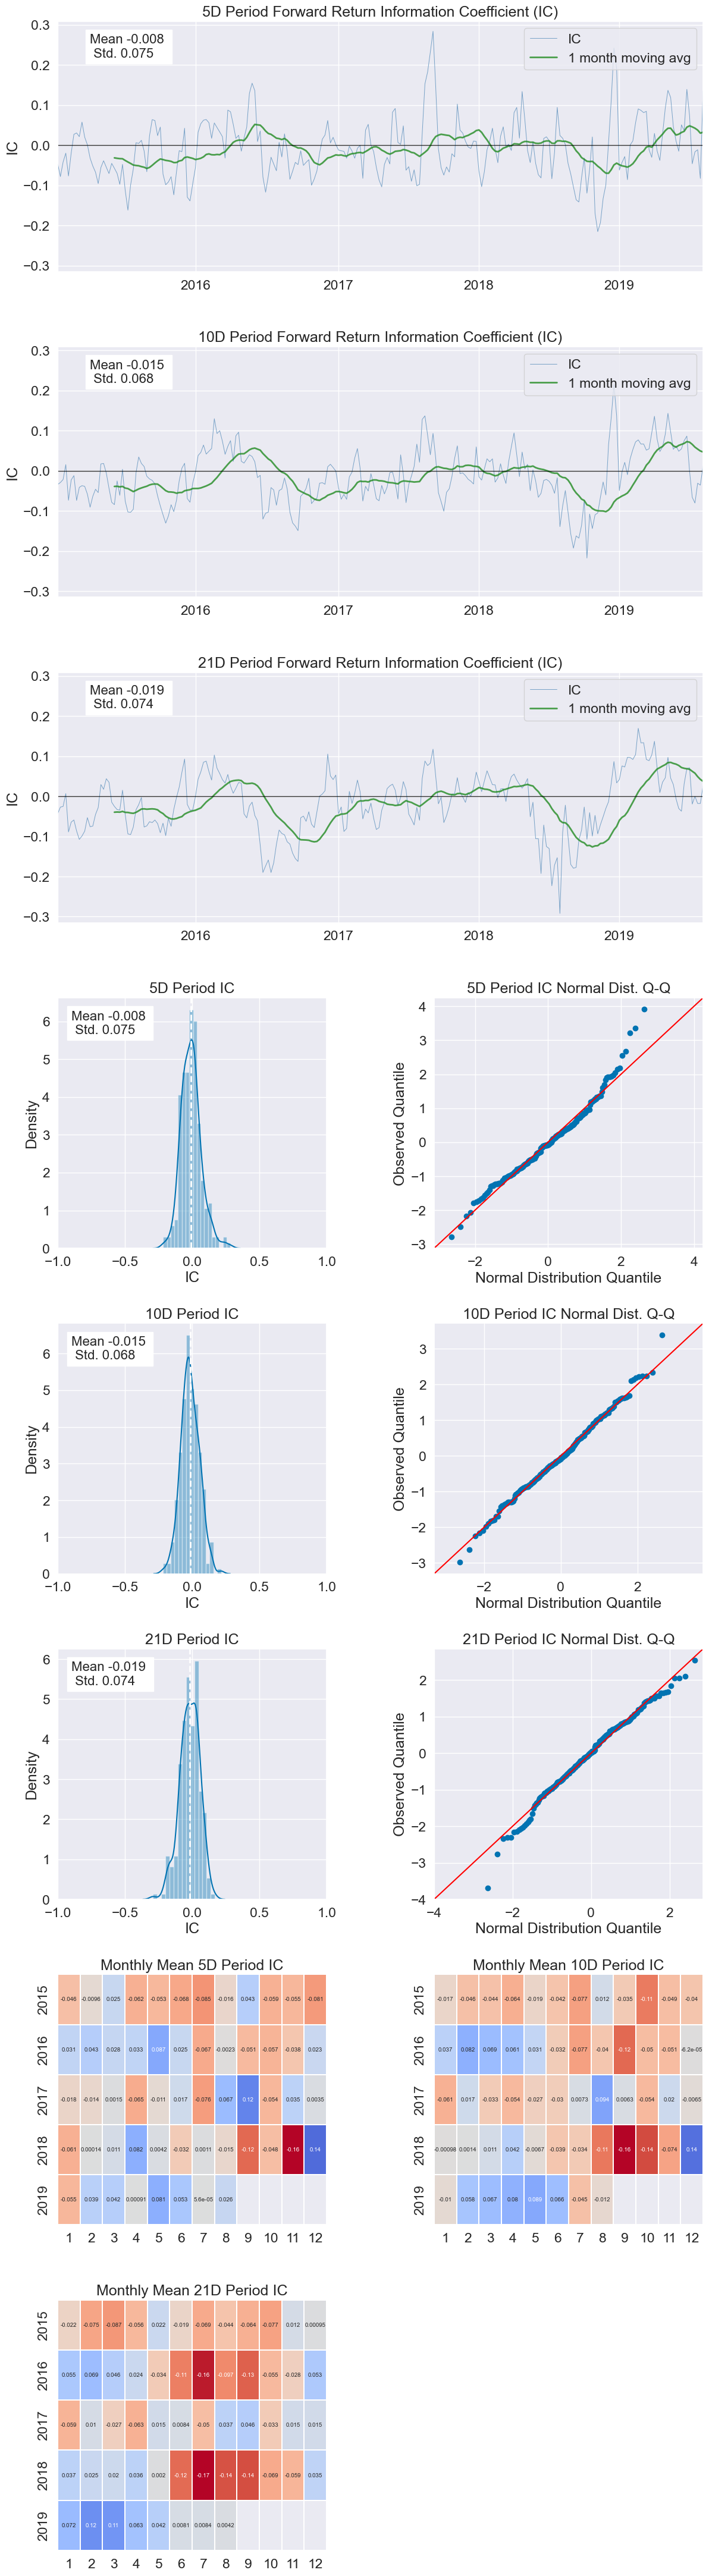

AttributeError: 'Index' object has no attribute 'get_values'

In [18]:
create_full_tear_sheet(factor_data)